In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import csv
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    Resize,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.1.0
Numpy version: 1.24.0
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/monai/jupyter/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/lat

In [7]:
os.environ["MONAI_DATA_DIRECTORY"] = './'
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
image_dir = root_dir + 'chestmnist/'
print(root_dir)
print(os.getcwd())

./
/home/monai/MedNIST/chestMNIST


In [8]:
# dataset downloaded via cli
# https://github.com/MedMNIST/MedMNIST
# python -m medmnist download --root=.
# python -m medmnist save --flag=chestmnist --root=. --folder=. --postfix=png

In [9]:
set_determinism(seed=0)


In [59]:
train = 'TRAIN'
validation = 'VALIDATION'
test= 'TEST'

class_names = [
    'atelectasis',
    'cardiomegaly',
    'effusion',
    'infiltration',
    'mass',
    'nodule',
    'pneumonia',
    'pneumothorax',
    'consolidation',
    'edema',
    'emphysema',
    'fibrosis',
    'pleural',
    'hernia',
    'none'
]

#none = 'none'
#pneumonia = 'pneumonia'
#class_names = [none, pneumonia]

num_class= len(class_names)

files = {
    train: [],
    validation: [],
    test: []
}

labels = {
    train: [],
    validation: [],
    test: []
}
with open(root_dir + 'chestmnist.csv', newline='') as csvfile:
  #  counter = 0
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
     #   counter = counter + 1
        classifiers = row[2:(num_class+2)]
        row_labels = []
        for index, i in enumerate(classifiers):
            if i == '1':
                row_labels.append(index)
        
        if len(row_labels) == 0:
            row_labels.append(14)
            
        for label in row_labels:
            files[row[0]].append(image_dir + row[1])
            labels[row[0]].append(label)
     #   print(classifiers)
     #   print(row_labels)
        
     #   if counter == 10:
    #        break;
image_width, image_height = PIL.Image.open(files[train][0]).size


print(f"Image dimensions: {image_width} x {image_height}")
print(len(files[train]))
print(len(labels[train]))
print(len(files[validation]))
print(len(labels[validation]))
print(len(files[test]))
print(len(labels[test]))

print(files[train][1200])
print(labels[train][1200])

Image dimensions: 28 x 28
98905
98905
14057
14057
28438
28438
./chestmnist/train944_0_0_1_0_0_0_0_0_1_0_0_0_0_0.png
8


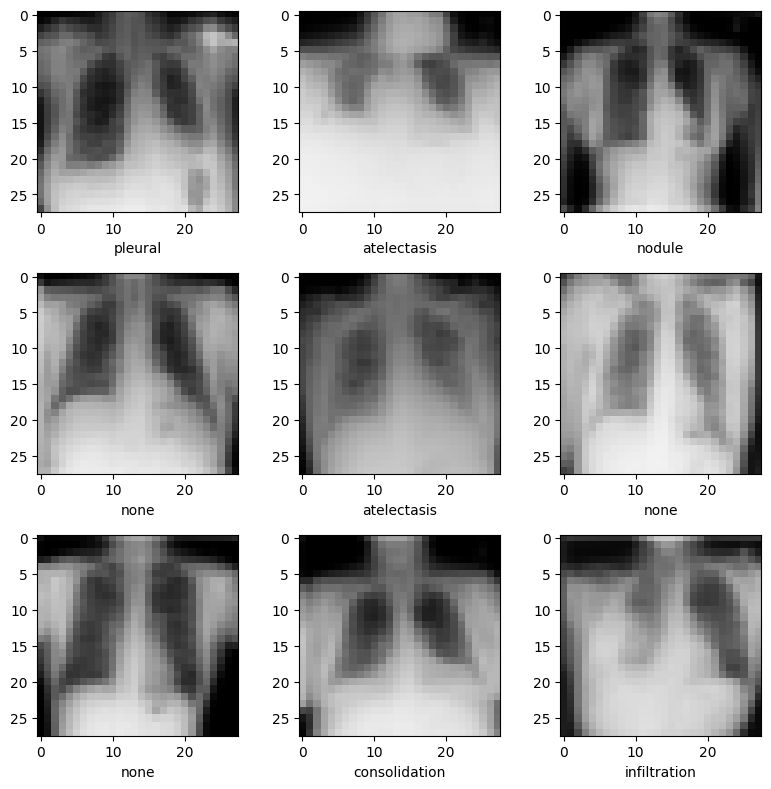

In [60]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(len(files[train]), size=9)):
    im = PIL.Image.open(files[train][k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[labels[train][k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [61]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        Resize([64, 64]),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [
        LoadImage(image_only=True), 
        EnsureChannelFirst(), 
        ScaleIntensity(),
        Resize([64, 64]),
    ]
)

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [62]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(files[train], labels[train], train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=30, shuffle=True, num_workers=8)

val_ds = MedNISTDataset(files[validation], labels[validation], val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=300, num_workers=8)

test_ds = MedNISTDataset(files[test], labels[test], val_transforms)
test_loader = DataLoader(
    test_ds, batch_size=300, num_workers=8)

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [64]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
       # if step % 200 == 0:
     #       print(f"At step: {step}/{len(train_ds) // train_loader.batch_size}")
       # print(
       #     f"{step}/{len(train_ds) // train_loader.batch_size}, "
       #     f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/100
epoch 1 average loss: 1.9377
saved new best metric model
current epoch: 1 current AUC: 0.6529 current accuracy: 0.4402 best AUC: 0.6529 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.8623
saved new best metric model
current epoch: 2 current AUC: 0.6694 current accuracy: 0.4423 best AUC: 0.6694 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 1.8474
saved new best metric model
current epoch: 3 current AUC: 0.6806 current accuracy: 0.4424 best AUC: 0.6806 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 1.8338
saved new best metric model
current epoch: 4 current AUC: 0.6858 current accuracy: 0.4437 best AUC: 0.6858 at epoch: 4
----------
epoch 5/100
epoch 5 average loss: 1.8248
saved new best metric model
current epoch: 5 current AUC: 0.6925 current accuracy: 0.4449 best AUC: 0.6925 at epoch: 5
----------
epoch 6/100
epoch 6 average loss: 1.8148
saved new best metric model
current epoch: 6 current AUC: 0.7020 current accuracy: 0.4449 bes

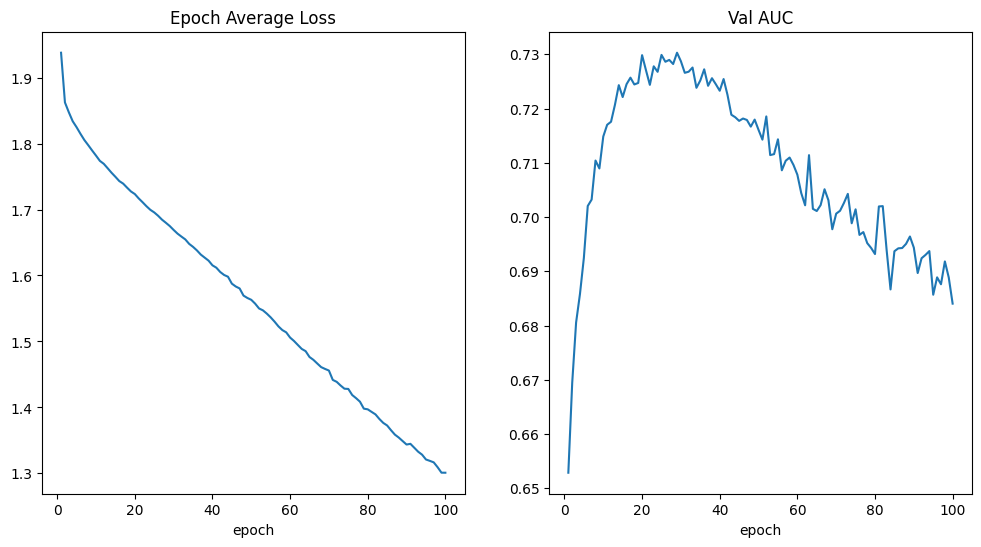

In [65]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [66]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [67]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4, zero_division="warn"))

               precision    recall  f1-score   support

  atelectasis     0.2052    0.0880    0.1232      2420
 cardiomegaly     0.2547    0.0704    0.1104       582
     effusion     0.2638    0.2923    0.2773      2754
 infiltration     0.2433    0.2115    0.2263      3938
         mass     0.2092    0.0600    0.0933      1133
       nodule     0.3333    0.0007    0.0015      1335
    pneumonia     0.0000    0.0000    0.0000       242
 pneumothorax     0.1817    0.1111    0.1379      1089
consolidation     0.0000    0.0000    0.0000       957
        edema     0.1282    0.0121    0.0221       413
    emphysema     0.1034    0.0118    0.0212       509
     fibrosis     0.0000    0.0000    0.0000       362
      pleural     0.3333    0.0014    0.0027       734
       hernia     0.0000    0.0000    0.0000        42
         none     0.5300    0.8737    0.6597     11928

     accuracy                         0.4401     28438
    macro avg     0.1857    0.1155    0.1117     28438
 weighte

/home/monai/jupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/monai/jupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/monai/jupyter/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
print(os.path.join(root_dir, "best_metric_model.pth"))

./best_metric_model.pth


In [69]:
torch.jit.script(model).save(root_dir + "classifier.zip")